# textCNN

## 1.实际训练阶段

### 1.1引入模块库

In [1]:
from MyModule import Net
import cupy as cp
import numpy
import matplotlib as plt

Enjoy NPL MachineLearning


### 1.2导入数据集
格式为 batch h= w channels

#### 训练集

In [2]:
x_1 = numpy.load('Data/positive.npy',allow_pickle=True)
x_2 = numpy.load('Data/negative.npy',allow_pickle=True)
y_1 = numpy.repeat([[0,1]],109,axis=0) # 正类
y_2 = numpy.repeat([[1,0]],202,axis=0) # 负类
print(f"x_1 shape:{x_1.shape} x_2 shape; {x_2.shape}")
print(f"y_1 shape:{y_1.shape} y_2 shape: {y_2.shape}") 
origin_X = numpy.concatenate((x_1,x_2))
origin_Y = numpy.concatenate((y_1,y_2))
# 打乱数据集
train_X = origin_X[0:210,:,:]
train_Y = origin_Y[0:210,:]
per = numpy.random.permutation(train_X.shape[0])#打乱后的行号
train_x = train_X[per, :, :]#获取打乱后的训练数据
train_y = train_Y[per]
print(train_x.shape)
print(train_y.shape)
train_x = train_x.reshape((210,20,100,1))
train_x = cp.asarray(train_x)
train_y = cp.asarray(train_y)
print(train_x.shape,train_y.shape)

train_shape = train_x.shape


x_1 shape:(109, 20, 100) x_2 shape; (202, 20, 100)
y_1 shape:(109, 2) y_2 shape: (202, 2)
(210, 20, 100)
(210, 2)
(210, 20, 100, 1) (210, 2)


#### 测试集

In [3]:
valid_X = origin_X[210:,:,:]
valid_Y = origin_Y[210:,:]
valid_X = numpy.concatenate((x_1,valid_X))
valid_Y = numpy.concatenate((y_1,valid_Y))
valid_x = cp.asarray(valid_X.reshape(210,20,100,1))
valid_y = cp.asarray(valid_Y)
valid_shape = valid_x.shape
print("Valid X Shape: ",valid_x.shape)
print("Valid Y Shape: ",valid_y.shape)                    

Valid X Shape:  (210, 20, 100, 1)
Valid Y Shape:  (210, 2)


### 1.3定义网络结构

In [4]:
# 卷积层
conv1 = Net.Conv(kernal=(3,100,1,10),stride=1)
conv2 = Net.Conv(kernal=(4,100,1,10),stride=1)
conv3 = Net.Conv(kernal=(5,100,1,10),stride=1)

# 激活函数Relu
relu1 = Net.Relu()
relu2 = Net.Relu()
relu3 = Net.Relu()

# 池化层
max_pooling1 = Net.Pool(ksize=2)
max_pooling2 = Net.Pool(ksize=2)
max_pooling3 = Net.Pool(ksize=2)

# Flatten 层
flatten1 = Net.Flatten()
flatten2 = Net.Flatten()
flatten3 = Net.Flatten()

# Concat融合
concat1 = Net.Concat()

# 全连接层
fc1 = Net.Fc(250,2)

# softmax
softmax = Net.Softmax()

### 定义前向传播函数

In [5]:
def Forward(X,Y):
    # 卷积
    forward1 = conv1.forward(X)
    forward2 = conv2.forward(X)
    forward3 = conv3.forward(X)
    # print(forward1.shape)
    # relu
    forward1 = relu1.forward(forward1)
    forward2 = relu2.forward(forward2)
    forward3 = relu3.forward(forward3)
    # print(forward1.shape)
    # 池化
    forward1 = max_pooling1.forward(forward1)
    forward2 = max_pooling2.forward(forward2)
    forward3 = max_pooling3.forward(forward3)
    # print(forward1.shape)
    # flatten
    forward1 = flatten1.forward(forward1)
    forward2 = flatten2.forward(forward2)
    forward3 = flatten3.forward(forward3)
    # print(forward1.shape)
    # print(forward2.shape)
    # print(forward3.shape)
    # concate
    forward = concat1.forward(forward1,forward2,forward3)
    # print(forward.shape)
    # 全连接
    forward = fc1.forward(forward)
    # print(forward.shape)
    # softmax
    loss,delta = softmax.calcuteLoss(forward,Y)
    predict = softmax.predict(forward)
    right = 0
    # print(predict.shape)
    for i in range(X.shape[0]):
        if cp.argmax(predict[i])==cp.argmax(Y[i]) :
            right = right + 1
    return loss,delta,right/X.shape[0]
# print(f"softmax_layer:{delta.shape}" )
# print(f"loss:{loss} delta:{delta}")

### 定义反向传播函数

In [6]:
def Backward(delta,lr):
    # 全连接
    backward = fc1.backward(delta,lr)
    # print(f"fc:{backward.shape}")
    # concate
    backward1,backward2,backward3 =  concat1.backward(backward)
    # print(f"concate:{backward1.shape} {backward2.shape} {backward3.shape}")
    # flatten
    backward1 = flatten1.backward(backward1)
    backward2 = flatten2.backward(backward2)
    backward3 = flatten3.backward(backward3)
    # print(f"flatten1:{backward1.shape} flatten2:{backward2.shape} flatten3:{backward3.shape}")
    # 池化
    backward1 = max_pooling1.backward(backward1)
    backward2 = max_pooling2.backward(backward2)
    backward3 = max_pooling3.backward(backward3)
    # print(f"pool1:{backward1.shape} pool2:{backward2.shape} pool3:{backward3.shape}")
    # relu
    backward1 = relu1.backward(backward1)
    backward2 = relu2.backward(backward2)
    backward3 = relu3.backward(backward3)
    # 卷积
    backward1 = conv1.backward(backward1,lr)
    backward2 = conv2.backward(backward2,lr)
    backward3 = conv3.backward(backward3,lr)
    # print(f"反向传播完成")

#### 1.4.3训练结果和损失展示

In [7]:
learning_rate = 0.005
batch_size = 10
epoches =2
num = 0
axis_x = numpy.array([])
loss_y = numpy.array([])
for epoch in range(epoches+1):
    for i in range(0,valid_shape[0],batch_size): 
        X = train_x[i:i+batch_size]
        Y = train_y[i:i+batch_size]
        loss,delta,right_rate= Forward(X,Y)
        # print("==============================================")
        print(f"epoch-{epoch}/{epoches}-{i}/{311} loss:{loss:.3f}")
        
        Backward(delta,learning_rate)
        loss_y = numpy.append(loss_y,loss.astype(numpy.float_))
        axis_x = numpy.append(axis_x,num)
        num = num +1 
        # print(loss_y)
        
    learning_rate *= 0.95**(epoch+1)
    

epoch-0/2-0/311 loss:0.585
epoch-0/2-10/311 loss:0.463
epoch-0/2-20/311 loss:0.314
epoch-0/2-30/311 loss:0.132
epoch-0/2-40/311 loss:0.229
epoch-0/2-50/311 loss:0.132
epoch-0/2-60/311 loss:0.113
epoch-0/2-70/311 loss:0.115
epoch-0/2-80/311 loss:0.029
epoch-0/2-90/311 loss:0.096
epoch-0/2-100/311 loss:0.049
epoch-0/2-110/311 loss:0.046
epoch-0/2-120/311 loss:0.064
epoch-0/2-130/311 loss:0.049
epoch-0/2-140/311 loss:0.028
epoch-0/2-150/311 loss:0.018
epoch-0/2-160/311 loss:0.061
epoch-0/2-170/311 loss:0.016
epoch-0/2-180/311 loss:0.047
epoch-0/2-190/311 loss:0.045
epoch-0/2-200/311 loss:0.028
epoch-1/2-0/311 loss:0.041
epoch-1/2-10/311 loss:0.045
epoch-1/2-20/311 loss:0.042
epoch-1/2-30/311 loss:0.023
epoch-1/2-40/311 loss:0.044
epoch-1/2-50/311 loss:0.032
epoch-1/2-60/311 loss:0.030
epoch-1/2-70/311 loss:0.034
epoch-1/2-80/311 loss:0.010
epoch-1/2-90/311 loss:0.032
epoch-1/2-100/311 loss:0.018
epoch-1/2-110/311 loss:0.018
epoch-1/2-120/311 loss:0.026
epoch-1/2-130/311 loss:0.021
epoch-1

#### 1.4.4 预测结果展示

In [8]:

batch_size = 1
epoches =1
count = 0

for i in range(0,valid_shape[0],batch_size): 
    X = valid_x[i:i+batch_size]
    Y = valid_y[i:i+batch_size]
    loss,delta,right_rate= Forward(X,Y)
    if right_rate==1 : count= count+1
    # print(right_rate)
print(f"right_rate: {(count/(valid_x.shape[0]))*100}%")


right_rate: 100.0%


### 训练数据及分类器性能展示

#### 损失变化图

Text(0.5, 1.0, 'Loss function')

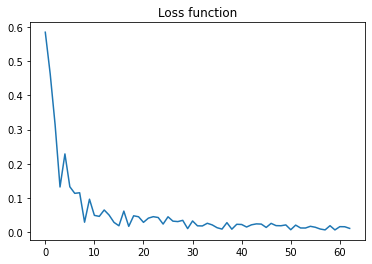

In [9]:
import matplotlib.pyplot as plt
import numpy
axis_x = cp.asarray(axis_x)
# print(type(loss_y[0].astype(numpy.float_)))
# print(type(axis_x))
loss_y = cp.asarray(loss_y)
axis_x_1 = numpy.array(list(map(eval,map(str,axis_x))))
loss_y_1 = numpy.array(list(map(eval,map(str,loss_y))))
plt.plot(axis_x_1,loss_y_1)
plt.title("Loss function")

#### 混淆矩阵

> - 正样本 0 1 
> - 负样本 1 0

##### TP = 正类判定为正类/正类全
##### FN = 正类判定为负类/正类全
##### FP = 负类判定为正类/负类全
##### TN = 负类判定为负类/负类全

In [10]:
batch_size = 1
epoches =1
count = 0
TP=FN=FP=TN=0
Tcount = 0
Fcount = 0
for i in range(0,valid_shape[0],batch_size): 
    X = valid_x[i:i+batch_size]
    Y = valid_y[i:i+batch_size]
    
    loss,delta,right_rate= Forward(X,Y)
    if Y[0][1] == 1 :
        Tcount=Tcount+1
        if right_rate==1:
            TP = TP+1
        else:
            FN = FN+1
    else :
        Fcount=Fcount+1
        if right_rate==1:
            TN = TN+1
        else:
            FP = FP +1
print(f"TP={TP} FN={FN} FP={FP} TN={TN} ")
print(f"Ture Smaples:{Tcount} False Samples:{Fcount}")

TP=109 FN=0 FP=0 TN=101 
Ture Smaples:109 False Samples:101


#### 准确率

In [11]:
Accuracy = (TP+TN)/(TP+TN+FP+FN)
print(f"Accuracy={Accuracy}")

Accuracy=1.0


#### 精确率（精准率）

In [12]:
Precision = TP/(TP+FP)
print(f"Precision={Precision}")

Precision=1.0


#### 召回率

In [13]:
Recall = TP/(TP+FN) 
print(f"Recall={Recall}")

Recall=1.0


#### F1值

In [14]:
F1 = 2*TP/(2*TP+FP+FN)
print(f"F1={F1}")

F1=1.0


ROC曲线

Text(0.5, 1.0, 'ROC Curve')

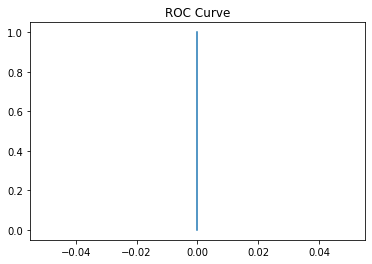

In [15]:
batch_size = 1
ROC_x = []
ROC_y = []
result = []
for i in range(0,valid_shape[0],batch_size):
    X = valid_x[i:i+batch_size]
    Y = valid_y[i:i+batch_size]
    tmp_x = []
    loss,delta,right_rate= Forward(X,Y)
    if Y[0][1] == 1 :
        tmp_x = [1,list(map(eval,map(str,[softmax.softmax[0][1]])))[0]]
    else :
        tmp_x = [0,list(map(eval,map(str,[softmax.softmax[0][1]])))[0]]
    result.append(tmp_x)
    # print(softmax.softmax[0])
# sort 
# result[ [label true_value] ]
num = 0
result.sort(key= lambda x:x[1],reverse=True)
for i in range(0,100):
    x = i/100
    true_sampes = 0 
    TP=FP=FN=TN=0
    for j in range(0,valid_shape[0]):
        threshold =1-x
        # 认定为正样本
        if result[j][1]>=threshold:
            if result[j][0]==1 : TP = TP + 1
            else: FP = FP + 1
        else:
            if result[j][0]==0: TN = TN + 1
            else: FN = FN + 1
        
        
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    # print(FPR,TPR)
    ROC_x.append(FPR)
    ROC_y.append(TPR)
plt.plot(ROC_x,ROC_y)
plt.title("ROC Curve")

AUC值

In [16]:
AUC = 0
for i in range(len(ROC_x)):
    AUC += 0.01*ROC_y[i]
print(f"AUC={AUC}")

AUC=0.9700000000000006


### 训练参考内容

上面在将正负样本的时候其实已经提到了相关的内容。

当模型训练后的效果较差时，例如准确率低于60%（这个百分比只是个参考，表达大致模型已经初步成型的意思），召回不理想（因为我的应用场景无法评估线上被识别对象的总量，所以召回率没有做评估），那就证明“学习资料”出了问题。

如果召回率低，那就要补充正样本，让正样本的共性特征更明显；如果精确率低，那么就补充负样本，一方面要让正负样本由较明显的特征差异，另一方面可以把模型误召回的文本补充到负样本，矫正模型学偏的部分。

In [17]:
import pickle
ClassDict = open("Model.pkl", 'wb')
Model={"conv1":conv1,"conv2":conv2,"conv3":conv3,
      "relu1":relu1,"relu2":relu2,"relu3":relu3,
      "max_pooling1":max_pooling1,"max_pooling2":max_pooling2,"max_pooling3":max_pooling3,
      "flatten1":flatten1,"flatten2":flatten2,"flatten3":flatten3,
      "concat1":concat1,
      "fc1":fc1,
      "softmax":softmax}
serilizeStr = pickle.dumps(Model)
ClassDict.write(serilizeStr)
ClassDict.close()
